# Imports

In [1]:
%%capture

import math
import db_func
import pandas as pd
import numpy as np
from tqdm import notebook
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
import matplotlib.pyplot as plt
from datetime import date
#notebook.tqdm(looping)

try:
    %load_ext autotime
    %load_ext jupyterlab_notify
except:
    !pip3 install ipython-autotime
    %load_ext autotime

time: 1.29 s (started: 2021-08-14 18:17:36 -04:00)


## Get Database Connection

In [2]:
conn = db_func.get_conn()

time: 2.65 ms (started: 2021-08-14 18:17:37 -04:00)


# Preprocessing

match_df: The final processed dataset to be used in the machine learning models 

## Populate Dataframes From Database

### SQL Query

In [3]:
match_query = '''SELECT
                    m.match_id,  m.away_id, m.home_id,
                    m.date, m.away_pts, m.home_pts, m.playoff_game,
                    h_ml.home_ml, a_ml.away_ml,
                    h_ps.home_spread, a_ps.away_spread,
                    h_ps.home_ps_odds, a_ps.away_ps_odds,
                    over.over, under.under, ou.spread
                FROM match AS m
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS home_ml,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 1 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.home_id
                    GROUP BY m.match_id
                ) AS h_ml ON m.match_id = h_ml.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS away_ml,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 1 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.away_id
                    GROUP BY m.match_id
                ) AS a_ml ON m.match_id = a_ml.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS home_ps_odds,
                        AVG(spread) AS home_spread,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 2 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.home_id
                    GROUP BY m.match_id
                ) AS h_ps ON m.match_id = h_ps.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS away_ps_odds,
                        AVG(spread) AS away_spread,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 2 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.away_id
                    GROUP BY m.match_id
                ) AS a_ps ON m.match_id = a_ps.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS under,
                        m.match_id AS match_id
                    FROM
                        odds AS o, match AS m
                    WHERE
                        o.bet_type_id = 3 AND
                        o.over_under = 'under' AND
                        o.match_id = m.match_id
                    GROUP BY m.match_id
                ) AS under ON m.match_id = under.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS over,
                        m.match_id AS match_id
                    FROM
                        odds AS o, match AS m
                    WHERE
                        o.bet_type_id = 3 AND
                        o.over_under = 'over' AND
                        o.match_id = m.match_id
                    GROUP BY m.match_id
                ) AS over ON m.match_id = over.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(spread) AS spread,
                        m.match_id AS match_id
                    FROM
                        odds AS o, match AS m
                    WHERE
                        o.bet_type_id = 3 AND
                        o.match_id = m.match_id
                    GROUP BY m.match_id
                ) AS ou ON m.match_id = ou.match_id
                ORDER BY date ASC
                '''
#                    WHERE m.date >= DATE('2007-10-30')

season_query = '''SELECT *
                  FROM season'''
player_performance_query = '''SELECT p.*, m.date
                              FROM player_performance as p, match as m
                              WHERE m.match_id = p.match_id
                              ORDER BY date ASC'''
team_query = '''SELECT * 
                FROM team_name'''
injury_query = '''SELECT * 
                FROM injury'''

match_df = pd.read_sql(match_query, conn)
#match_df.set_index('match_id', inplace=True)
season_df = pd.read_sql(season_query, conn)
playerperf_df = pd.read_sql(player_performance_query, conn)
team_df = pd.read_sql(team_query, conn)
injury = pd.read_sql(injury_query, conn)



time: 29.7 s (started: 2021-08-14 18:17:37 -04:00)


## Season

Set the season for each match

In [4]:
def get_season(date):
    return season_df[(season_df['start_date'] <= date) &
                     (season_df['end_date'] >= date)]['season'].values[0]

time: 251 µs (started: 2021-08-14 18:18:07 -04:00)


In [5]:
match_df['season'] = match_df['date'].map(get_season)

time: 4.4 s (started: 2021-08-14 18:18:07 -04:00)


Only matches from seasons 2008-2021 will be used 

# Feature Engineering

## Margin of Victory/Loss (MOVL) with respect to the home team

In [6]:
match_df['movl'] = match_df['home_pts'] - match_df['away_pts']

time: 736 µs (started: 2021-08-14 18:18:11 -04:00)


## Team Elo Rating

Each team starts at 1500 elo

In [7]:
match_df['home_elo'] = 1500.0
match_df['away_elo'] = 1500.0

time: 4.88 ms (started: 2021-08-14 18:18:11 -04:00)


### Get the previous match of each team to aid elo calculation

In [8]:
def get_prev_match(date, team_id, match_df):
    return match_df[(match_df["date"] < date) &
                    ((match_df["home_id"] == team_id) |
                     (match_df["away_id"] == team_id))].tail(1)

time: 424 µs (started: 2021-08-14 18:18:12 -04:00)


### Team elo calculation

In [9]:
def get_prev_elo(team_id, season, prev_match):

    if prev_match.empty:
        prev_elo = 1500.0
    elif team_id == prev_match['home_id'].values[0]:
        prev_elo = prev_match['home_elo'].values[0]
    elif team_id == prev_match['away_id'].values[0]:
        prev_elo = prev_match['away_elo'].values[0]
    else: 
        print('err')

    if (not prev_match.empty and
            (prev_match['season'].values[0]
             != season)):
        #print(prev_elo, prev_elo * 0.75 + 1505 * 0.25)
        prev_elo = prev_elo * 0.75 + 1505 * 0.25

    return prev_elo


def update_elo(home_elo, away_elo, movl):
    elo_diff = home_elo + 100.0 - away_elo
    if movl > 0:
        h_s = 1.0
        a_s = 0.0
        multiplier = ((movl+3)**(0.8))/(7.5+0.006*elo_diff)

    else:
        h_s = 0.0
        a_s = 1.0
        multiplier = ((-movl+3)**(0.8))/(7.5+0.006*(-elo_diff))
        
    exp_h_s = 1.0 / (1.0 + 10.0 ** (-elo_diff/400.0))
    exp_a_s = 1.0 - exp_h_s
    
    k = 20.0 * multiplier

    new_home_elo = home_elo + k * (h_s - exp_h_s)
    new_away_elo = away_elo + k * (a_s - exp_a_s)

    return (new_home_elo, new_away_elo)

time: 653 µs (started: 2021-08-14 18:18:12 -04:00)


In [10]:
for idx, row in match_df.iterrows():
    prev_h_match = get_prev_match(row['date'], row['home_id'], match_df)
    prev_a_match = get_prev_match(row['date'], row['away_id'], match_df)
    
    prev_h_elo = get_prev_elo(
        row['home_id'], row['season'], prev_h_match)
    prev_a_elo = get_prev_elo(
        row['away_id'], row['season'], prev_a_match)    
    
    new_elos = update_elo(prev_h_elo, prev_a_elo, row['movl'])
    match_df.at[idx, 'home_elo'] = new_elos[0]
    match_df.at[idx, 'away_elo'] = new_elos[1]

time: 40.8 s (started: 2021-08-14 18:18:12 -04:00)


In [11]:
match_df = match_df[match_df['date'] >= date(2007,10,30)]

time: 1.78 ms (started: 2021-08-14 18:18:52 -04:00)


In [14]:
def plot_elo(team_id):
    output_notebook()
    plot = figure(title="Historical Elo Rating", x_axis_label="Date", y_axis_label="Elo", 
                  x_axis_type = 'datetime', plot_width=800, plot_height=500)

    y = match_df[(match_df['away_id'] == team_id) | (match_df['home_id'] == team_id)]
    x = y['date']
    y = y.apply(lambda x: x['home_elo'] if x['home_id'] == team_id else x['away_elo'], axis=1)
    
    team_name = team_df[team_df['team_id'] == team_id]['team_name'].head(1).values[0]
    plot.circle(x, y, legend_label = team_name, line_color = 'blue', line_width = 1)

    handle = show(plot, notebook_handle=True)

    # Update the plot title in the earlier cell
    push_notebook(handle=handle)

plot_elo(10)


Loading BokehJS ...

time: 34.1 ms (started: 2021-08-14 18:18:59 -04:00)


from trueskill import Rating, quality_1vs1, rate_1vs1
alice, bob = Rating(25), Rating(30)  # assign Alice and Bob's ratings
if quality_1vs1(alice, bob) < 0.50:
    print('This match seems to be not so fair')
alice, bob = rate_1vs1(alice, bob)  # update the ratings after the match## Player Elo Rating

## Player elo rating

In [18]:
from trueskill import Rating, rate

def get_prev_player_perf(date, team_id, pp_df):
    return match_df[(pp_df["date"] < date) &
                    ((match_df["home_id"] == team_id) |
                     (match_df["away_id"] == team_id))].tail(1)

def update_player_elo(match_id, pp_df):
    
    home_players =
    
    
    pp_df['prev_elo'] = 
    
    home_team =  home_players['player_elo'].itertuples(index=False)
    away_team =  away_players['player_elo'].itertuples(index=False)
    
    match_duration = home_players['sp'].map(sum)
    
    home_wts = home_players['sp'].map(lambda x: x/match_duration).itertuples(index=False)
    away_wts = away_players['sp'].map(lambda x: x/match_duration).itertuples(index=False)
    
    playerperf_df['player_elo'] = rate(list(home_team, away_team), weights=list(home_wts, away_wts))
    
    
def get_players(match_id, team_id, pp_df):
    return  pp_df[(pp_df['match_id'] == match_id) &
                      (pp_df['team_id'] = team_id)]
    
    
match_df['home_player_elo_sum']


This match seems to be not so fair
time: 2.41 ms (started: 2021-08-14 18:58:43 -04:00)


In [32]:
for idx, row in match_df.iterrows():
    
    home_players = get_players(row['match_id'], row['home_id'], pp_df)
    away_players = get_players(row['match_id'], row['away_id'], pp_df)

    prev_home_elos = []
    prev_away_elos = []
    
    for player in home_players:
        prev_player_elo = get_prev_player_perf(row['date'], player['player_id'], pp_df)
        if prev_player_elo.empty:
            prev_player_elo = Rating()
        else:
            prev_player_elo = prev_player_elo['player_elo']
        prev_home_elos.append(prev_player_elo)
    
    for player in away_players:
        prev_player_elo = get_prev_player_perf(row['date'], player['player_id'], pp_df)
        if prev_player_elo.empty:
            prev_player_elo = Rating()
        else:
            prev_player_elo = prev_player_elo['player_elo']
        prev_away_elos.append(prev_player_elo)
    
    prev_home_elos = tuple(home_elos)  
    prev_away_elos = tuple(away_elos)  
    
    
    if row['home_win'] == 1:
        new ratings = rate([prev_home_elos, prev_away_elos], weights = [home_wts, away_wts])
    else:
        new ratings = rate([prev_away_elos, prev_home_elos], weights = [away_wts, home_wts])

    len_home_payers = len(home_players)
    for i in range(len_home_payers):
        home_players[i]['player_elo'] = new_ratings[i]
    for i in range(len(away_players)):
        away_players[i]['player_elo'] = new_ratings[i+len_home_payers]
    
    # Update match average player elo
    # for specific positions
    
    new_elos = update_elo(prev_h_elo, prev_a_elo, row['movl'])
    match_df.at[idx, 'home_elo'] = new_elos[0]
    match_df.at[idx, 'away_elo'] = new_elos[1]



SyntaxError: invalid syntax (4289053318.py, line 30)

time: 1.11 ms (started: 2021-08-14 22:10:54 -04:00)


In [31]:
from trueskill import rate
a = Rating()
b = Rating()
c = Rating()
d = Rating()
# first tuple is winner
rate([(a,b),(c,d)], weights=[(1,1),(1,1), ranks = [0,1]])


SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (1472998945.py, line 6)

time: 778 µs (started: 2021-08-14 22:05:15 -04:00)


## Player Efficiency Rating (PER) Sum of Last 5 Games

The Hollinger Player Efficiency Rating for a player is defined as the sum of
the following stats


| Stat | Weight |
| --- | ----------- |
| FGM | 85.910 |
| Steals | 53.897 |
| 3PTM | 51.757 |
| FTM | 46.845 |
| Blocks | 39.190 |
| Offensive Rebounds | 39.190|
| Assists | 34.677 |
| Defensive Rebounds | 14.707 |
| Foul | -17.174 |
| FT Miss | -20.091 |
| FG Miss | -39.190 |
| Turnover | -53.897 |

 divided by (minutes played).

In [16]:
def player_match_eff_rating(player):
    per = 0
    if player['sp'] > 0:
        per = player['fg'] * 85.910 
        + player['stl'] * 53.897
        + player['threep'] * 51.757
        + player['ft'] * 46.845
        + player['blk'] * 39.190 
        + player['orb'] * 39.190
        + player['drb'] * 34.677
        + player['ast'] * 14.707
        - player['pf'] * 17.174 
        - (player['fta'] - player['ft']) * 20.091 
        - (player['fga'] - player['fg']) * 39.190
        - player['tov'] * 53.897 
        
        per = per / (player['sp']/60.0)
    return per

def team_match_eff_rating(team_id, match_id, playerperf_df):
    df = playerperf_df[(playerperf_df['team_id'] == team_id) &
                        (playerperf_df['match_id'] == match_id)]
    return df['per'].sum()



time: 425 µs (started: 2021-08-14 15:29:23 -04:00)


In [17]:
### To get head on head matches for an opponent, set opponent_id
def get_prev_matches(date, team_id, match_df, opponent_id = -1):
    if opponent_id != -1:
        return match_df[(match_df["date"] < date) &
                        (((match_df["home_id"] == team_id) & 
                          (match_df["away_id"] == opponent_id)) |
                         ((match_df["home_id"] == opponent_id) & 
                          (match_df["away_id"] == team_id)))]
    else:
        return match_df[(match_df["date"] < date) &
                    ((match_df["home_id"] == team_id) |
                     (match_df["away_id"] == team_id))]

def get_past_per_sum(team_id, prev_matches, i):
    if len(prev_matches) < i: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x['home_per'] if x['home_id'] == team_id
                             else x['away_per'], axis=1)
    return prev_matches['res'].sum()    


time: 615 µs (started: 2021-08-14 15:29:23 -04:00)


In [18]:
playerperf_df['per'] = playerperf_df.apply(player_match_eff_rating, axis=1)

match_df['away_per'] = match_df.apply(lambda x: team_match_eff_rating(
    x['away_id'],x['match_id'], playerperf_df), axis=1)
match_df['home_per'] = match_df.apply(lambda x: team_match_eff_rating(
    x['home_id'],x['match_id'], playerperf_df), axis=1)

match_df['past_5_home_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                    match_df).tail(5),
                                                5), axis=1)
match_df['past_5_away_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                    match_df).tail(5),
                                                5), axis=1)

match_df['past_3_hth_home_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                     match_df,
                                                     x['away_id']
                                                    ).tail(3),
                                                3), axis=1)
match_df['past_3_hth_away_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                     match_df,
                                                     x['home_id']
                                                    ).tail(3),
                                                3), axis=1)

time: 2min 20s (started: 2021-08-14 15:29:23 -04:00)


## BPM 2.0 (BBREF)

### Get team average BPM for past 5 games

In [19]:
def get_past_bpm_sum(team_id, prev_matches, i):
    if len(prev_matches) < i: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x['home_bpm'] if x['home_id'] == team_id
                             else x['away_bpm'], axis=1)
    return prev_matches['res'].sum()

time: 263 µs (started: 2021-08-14 15:31:44 -04:00)


In [20]:
match_df['home_bpm'] = match_df.apply(lambda x: 
                        playerperf_df[(playerperf_df['match_id'] == x['match_id']) &
                        (playerperf_df['team_id'] == x['home_id'])]['bpm'].sum(), 
                                      axis=1)
match_df['away_bpm'] = match_df.apply(lambda x: 
                        playerperf_df[(playerperf_df['match_id'] == x['match_id']) &
                        (playerperf_df['team_id'] == x['away_id'])]['bpm'].sum(), 
                                      axis=1)
match_df['past_5_home_bpm'] = match_df.apply(lambda x: 
                                get_past_bpm_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                    match_df).tail(5),
                                                5), axis=1)
match_df['past_5_away_bpm'] = match_df.apply(lambda x: 
                                get_past_bpm_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                    match_df).tail(5),
                                                5), axis=1)
match_df['past_3_hth_home_bpm'] = match_df.apply(lambda x: 
                                get_past_bpm_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                     match_df,
                                                     x['away_id'],
                                                    ).tail(3),
                                                3), axis=1)
match_df['past_3_hth_away_bpm'] = match_df.apply(lambda x: 
                                get_past_bpm_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                     match_df,
                                                     x['home_id']
                                                    ).tail(3),
                                                3), axis=1)

time: 2min 8s (started: 2021-08-14 15:31:44 -04:00)


## Defensive Rating (DRTG)

In [21]:
def get_past_drtg_sum(team_id, prev_matches, i):
    if len(prev_matches) < i: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x['home_drtg'] if x['home_id'] == team_id
                             else x['away_drtg'], axis=1)
    return prev_matches['res'].sum()

time: 266 µs (started: 2021-08-14 15:33:52 -04:00)


In [22]:
match_df['home_drtg'] = match_df.apply(lambda x: 
                        playerperf_df[(playerperf_df['match_id'] == x['match_id']) &
                        (playerperf_df['team_id'] == x['home_id'])]['drtg'].sum(), 
                                      axis=1)
match_df['away_drtg'] = match_df.apply(lambda x: 
                        playerperf_df[(playerperf_df['match_id'] == x['match_id']) &
                        (playerperf_df['team_id'] == x['away_id'])]['drtg'].sum(), 
                                      axis=1)

match_df['past_5_home_drtg'] = match_df.apply(lambda x: 
                                get_past_drtg_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                    match_df).tail(5),
                                                 5), axis=1)
match_df['past_5_away_drtg'] = match_df.apply(lambda x: 
                                get_past_drtg_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                    match_df).tail(5),
                                                 5), axis=1)
match_df['past_3_hth_home_drtg'] = match_df.apply(lambda x: 
                                get_past_drtg_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                     match_df,
                                                     x['away_id']
                                                    ).tail(3),
                                                 3), axis=1)
match_df['past_3_hth_away_drtg'] = match_df.apply(lambda x: 
                                get_past_drtg_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                     match_df,
                                                     x['home_id']
                                                    ).tail(3),
                                                 3), axis=1)

time: 2min 12s (started: 2021-08-14 15:33:52 -04:00)


In [23]:
def get_past_pts_sum(team_id, prev_matches, i):
    if len(prev_matches) < i: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x['home_pts'] if x['home_id'] == team_id
                             else x['away_pts'], axis=1)
    return prev_matches['res'].sum()

time: 290 µs (started: 2021-08-14 15:36:05 -04:00)


In [24]:
match_df['past_5_home_pts'] = match_df.apply(lambda x: 
                                get_past_pts_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                    match_df).tail(5),
                                                5), axis=1)
match_df['past_5_away_pts'] = match_df.apply(lambda x: 
                                get_past_pts_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                    match_df).tail(5),
                                                5), axis=1)
match_df['past_3_hth_home_pts'] = match_df.apply(lambda x: 
                                get_past_pts_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                     match_df,
                                                     x['away_id']
                                                    ).tail(3),
                                                3), axis=1)
match_df['past_3_hth_away_pts'] = match_df.apply(lambda x: 
                                get_past_pts_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                     match_df,
                                                     x['home_id']
                                                    ).tail(3),
                                                3), axis=1)



time: 1min 51s (started: 2021-08-14 15:36:05 -04:00)


# Exploratory Data Analysis

Remove all rows where there were not enough games yet to calculate certain statistics

In [25]:
processed_df = match_df[(match_df['past_3_hth_home_bpm'].notnull()) &
                   (match_df['past_3_hth_away_bpm'].notnull())]

time: 2.91 ms (started: 2021-08-14 15:37:56 -04:00)


## Feature Correlation Matrix

In [26]:
features = ['home_elo', 'away_elo', 
            'past_5_home_bpm', 'past_5_away_bpm', 
            'past_5_home_per', 'past_5_away_per',
            'past_5_home_drtg', 'past_5_away_drtg',
            'past_5_home_pts', 'past_5_away_pts',
            'past_3_hth_home_bpm', 'past_3_hth_away_bpm', 
            'past_3_hth_home_per', 'past_3_hth_away_per',
            'past_3_hth_home_drtg', 'past_3_hth_away_drtg',
            'home_ml', 'away_ml']
corr_df = processed_df[features]

corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,home_elo,away_elo,past_5_home_bpm,past_5_away_bpm,past_5_home_per,past_5_away_per,past_5_home_drtg,past_5_away_drtg,past_5_home_pts,past_5_away_pts,past_3_hth_home_bpm,past_3_hth_away_bpm,past_3_hth_home_per,past_3_hth_away_per,past_3_hth_home_drtg,past_3_hth_away_drtg,home_ml,away_ml
home_elo,1.000000,0.052666,0.434603,0.032699,0.201354,-0.014781,-0.046267,0.001968,0.273111,0.005268,0.311758,0.016773,0.121285,-0.160700,-0.039043,0.188833,-0.500767,0.483020
away_elo,0.052666,1.000000,0.019166,0.435516,-0.010035,0.217736,0.014915,-0.043797,0.008565,0.290218,0.020531,0.302228,-0.145194,0.143525,0.204528,-0.029709,0.446647,-0.489084
past_5_home_bpm,0.434603,0.019166,1.000000,-0.000825,0.300489,-0.002857,-0.174269,0.001301,0.239193,0.020880,0.221366,-0.004876,0.065324,-0.047554,-0.024081,0.087056,-0.232238,0.232467
past_5_away_bpm,0.032699,0.435516,-0.000825,1.000000,0.002475,0.294823,0.016421,-0.174836,0.016111,0.233062,0.008223,0.205288,-0.045574,0.076140,0.097683,-0.022025,0.213972,-0.225498
past_5_home_per,0.201354,-0.010035,0.300489,0.002475,1.000000,0.138370,0.526816,0.089298,0.528142,0.210256,0.078482,-0.005681,0.287281,0.112787,0.177336,0.115964,-0.104302,0.132716
past_5_away_per,-0.014781,0.217736,-0.002857,0.294823,0.138370,1.000000,0.091467,0.539689,0.202738,0.548784,0.005797,0.083984,0.121609,0.295144,0.134445,0.186636,0.176660,-0.139119
past_5_home_drtg,-0.046267,0.014915,-0.174269,0.016421,0.526816,0.091467,1.000000,0.064390,0.179856,0.133129,-0.021023,0.009733,0.191731,0.094180,0.254128,0.070915,0.044351,-0.012958
past_5_away_drtg,0.001968,-0.043797,0.001301,-0.174836,0.089298,0.539689,0.064390,1.000000,0.127269,0.216297,0.004992,-0.014802,0.098235,0.192974,0.078313,0.261857,0.027720,0.028242
past_5_home_pts,0.273111,0.008565,0.239193,0.016111,0.528142,0.202738,0.179856,0.127269,1.000000,0.397596,0.095984,0.011342,0.252328,0.196206,0.102264,0.188692,-0.144634,0.130528
past_5_away_pts,0.005268,0.290218,0.020880,0.233062,0.210256,0.548784,0.133129,0.216297,0.397596,1.000000,0.012502,0.095704,0.207738,0.257736,0.202090,0.115500,0.207521,-0.210228


time: 48.9 ms (started: 2021-08-14 15:37:56 -04:00)


## Save Final Dataset into CSV

In [27]:
processed_df.to_csv('nba_data.csv', header=True, index=False)

time: 286 ms (started: 2021-08-14 15:37:57 -04:00)


# Machine Learning Models

# Splitting into Training and Test Sets

## Simple 80/20 split

In [15]:
import pandas as pd
import numpy as np
match_df = pd.read_csv('nba_data.csv')

features = ['home_elo', 'away_elo', 
            'past_5_home_bpm', 'past_5_away_bpm', 
            'past_5_home_per', 'past_5_away_per',
            'past_5_home_drtg', 'past_5_away_drtg',
            'past_5_home_pts', 'past_5_away_pts',
            'past_3_hth_home_bpm', 'past_3_hth_away_bpm', 
            'past_3_hth_home_per', 'past_3_hth_away_per',
            'past_3_hth_home_drtg', 'past_3_hth_away_drtg',
            'home_ml']

match_df['home_win'] = match_df['movl'].map(lambda x: 0 if x < 0 else 1)

cutoff = math.floor(len(match_df) * 0.8)
train = match_df[match_df.index < 14202]
test = match_df[match_df.index >= 14202]

time: 105 ms (started: 2021-08-14 18:43:06 -04:00)


## XGBoost

Accuracy: 0.693


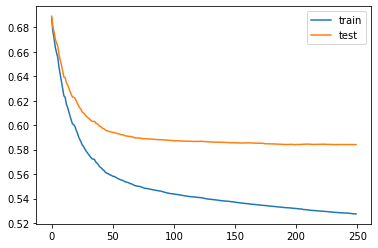

time: 2.15 s (started: 2021-08-14 18:43:08 -04:00)


In [16]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pylab as pl
import xgboost as xgb
import sklearn.metrics
from matplotlib import pyplot


features = ['home_elo', 'away_elo', 
            'past_5_home_bpm', 'past_5_away_bpm', 
            'past_5_home_drtg', 'past_5_away_drtg',
            'past_3_hth_home_drtg', 'past_3_hth_away_drtg',
            'home_ml']

X_train = train[features]
X_test = test[features]

# y_train = train['movl']
# y_test = test['movl']

y_train = train['home_win']
y_test = test['home_win']

evalset = [(X_train, y_train), (X_test,y_test)]

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'random_state': 1
}
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           learning_rate = 0.05,
                           max_depth = 5, 
                           alpha = 20,
                           n_estimators = 250,
                           min_child_weight=5,
                           random_state=1,
                           subsample=0.5,
                           use_label_encoder=False)

xg_reg.fit(X_train,y_train, eval_metric='logloss', eval_set =evalset, verbose=0)


# evaluate performance
yhat = xg_reg.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = xg_reg.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [31]:
y_pred = xg_reg.predict(X_test)
print(accuracy_score(y_test, y_pred))
xg_reg.predict_proba(X_test)

0.688573883161512


array([[0.3185504 , 0.6814496 ],
       [0.3721487 , 0.6278513 ],
       [0.5158733 , 0.48412672],
       ...,
       [0.4989121 , 0.5010879 ],
       [0.4989121 , 0.5010879 ],
       [0.46215576, 0.53784424]], dtype=float32)

time: 34.4 ms (started: 2021-08-14 16:51:32 -04:00)


In [ ]:
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'RMSE: {rmse}')
preds = pd.Series(preds, name='xgb_movl')
pred_df = pd.concat([y_test.reset_index(drop=True), 
                preds.reset_index(drop=True),
               test['home_ml'].reset_index(drop=True),
               test['away_ml'].reset_index(drop=True)], axis=1)
pred_df['home_win'] = pred_df['movl'].map(lambda x: 0 if x < 0 else 1)
pred_df['xgb_home_win'] = pred_df['xgb_movl'].map(lambda x: 0 if x < 0 else 1)
pred_df['correct_pred'] = pred_df.apply(lambda x: 
    1 if x['home_win'] == x['xgb_home_win'] else 0, axis = 1)
acc = pred_df['correct_pred'].sum()/len(df.index)
print(f'Accuracy: {acc}')

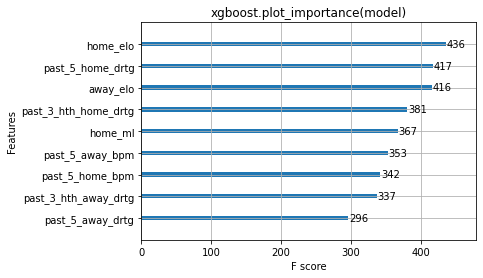

time: 89.3 ms (started: 2021-08-14 18:43:18 -04:00)


In [17]:

xgb.plot_importance(xg_reg)
pl.title("xgboost.plot_importance(model)")
pl.show()

## Accuracy of using just ML

In [ ]:
pred_df['ml_pred'] = pred_df.apply(lambda x: 
    1 if x['home_ml'] < x['away_ml'] else 0, axis = 1)

pred_df['ml_correct_pred'] = pred_df.apply(lambda x: 
    1 if x['home_win'] == x['ml_pred'] else 0, axis = 1)

acc = pred_df['ml_correct_pred'].sum()/len(df.index)
acc

## Tuning XGBoost

In [ ]:
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### TimeSeriesSplit

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as pl
import xgboost as xgb


tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

#xgb_model = xgb.XGBRegressor()
xgb_model = xgb.XGBClassifier(use_label_encoder=False)

match_df = pd.read_csv('nba_data.csv')

features = ['home_elo', 'away_elo', 
            'past_5_home_bpm', 'past_5_away_bpm', 
            'past_5_home_drtg', 'past_5_away_drtg',
            'home_ml']

match_df['home_win'] = match_df['movl'].map(lambda x: 0 if x < 0 else 1)

cutoff = math.floor(len(match_df) * 0.8)
train = match_df[match_df.index < 14202]
test = match_df[match_df.index >= 14202]

X_train = train[features]
X_test = test[features]

# y_train = train['movl']
# y_test = test['movl']

y_train = train['home_win']
y_test = test['home_win']


In [ ]:
params = {
        'min_child_weight': [5, 7, 9, 11, 13],
        'gamma': [0.05, 0.1, 0.25, 0.5, 0.75],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'max_depth': [3, 5, 7, 9],
        'n_estimators': range(50,200,50),
        'random_state': [1],
        'eta':[0.1,0.3,0.5,0.7]
        }
# grid_search = GridSearchCV(estimator = xgb_model, 
#                            cv = tscv, 
#                            scoring = 'neg_root_mean_squared_error',
#                            param_grid = params)
grid_search = GridSearchCV(estimator = xgb_model, 
                           cv = tscv, 
                           scoring = 'accuracy',
                           param_grid = params)
grid_search.fit(X_train, y_train)

### GridsearchCV

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
grid_search.best_estimator_.predict_proba(X_test)

In [ ]:
cv_preds = grid_search.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, cv_preds))
print(f'RMSE: {rmse}')

pred_df['xgbcv_movl'] = cv_preds
pred_df['xgbcv_home_win'] = pred_df['xgbcv_movl'].map(lambda x: 0 if x < 0 else 1)
pred_df['correct_cv_pred'] = pred_df.apply(lambda x: 
     1 if x['home_win'] == x['xgbcv_home_win'] else 0, axis = 1)
acc = pred_df['correct_cv_pred'].sum()/len(df.index)
acc

### Save tuned model

In [ ]:
import pickle
file_name = "xgb_reg.pkl"
# save
pickle.dump(grid_search.best_estimator_, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [ ]:
xgb.plot_importance(xgb_model_loaded)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [ ]:
for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]


## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression 
from sklearn import preprocessing

from sklearn import metrics

features = ['home_elo', 'away_elo', 
            'past_5_home_bpm', 'past_5_away_bpm', 
            'past_5_home_pts', 'past_5_away_pts',
            'past_5_home_drtg', 'past_5_away_drtg',
            'home_ml']


lr_train = train.replace([np.inf, -np.inf], np.nan).dropna(subset=features, how="any")

X_train = lr_train[features]
X_test = test[features]

y_train = lr_train['home_win']
y_test = test['home_win']


# Check for Nan's and inf's
print(f"Has Nan's: {np.any(np.isnan(X_train))}")
print(X_train[X_train.isna().any(axis=1)])
print(X_train.index[np.isinf(X_train).any(1)])
print(f"All Finite: {np.all(np.isfinite(X_train))}")
print(X_train.index[np.isinf(X_train).any(1)])

print(f"Has Nan's: {np.any(np.isnan(y_train))}")
print(y_train[y_train.isna()])
print(f"All Finite: {np.all(np.isfinite(y_train))}")

params={"C":np.logspace(-3,3,7)}# l1 lasso l2 ridge
logreg=LogisticRegression(random_state=1,max_iter=1000)
logreg_cv=GridSearchCV(logreg,params,cv=10)

# lr_model = LogisticRegression(random_state=1,max_iter=1000)
# lr_model.fit(X_train, y_train)

logreg_cv.fit(X_train, y_train)
y_pred = logreg_cv.predict(X_test)

#pred_df['lr_preds'] = y_pred

print(metrics.accuracy_score(y_test, y_pred))

Has Nan's: False
Empty DataFrame
Columns: [home_elo, away_elo, past_5_home_bpm, past_5_away_bpm, past_5_home_pts, past_5_away_pts, past_5_home_drtg, past_5_away_drtg, home_ml]
Index: []
Int64Index([], dtype='int64')
All Finite: True
Int64Index([], dtype='int64')
Has Nan's: False
Series([], Name: home_win, dtype: int64)
All Finite: True
0.6967353951890034
time: 5.86 s (started: 2021-08-14 16:51:37 -04:00)


In [33]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",logreg_cv.best_estimator_)
print("\n The best score across ALL searched params:\n",logreg_cv.best_score_)
print("\n The best parameters across ALL searched params:\n",logreg_cv.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 LogisticRegression(C=10.0, max_iter=1000, random_state=1)

 The best score across ALL searched params:
 0.7236718478595322

 The best parameters across ALL searched params:
 {'C': 10.0}
time: 1.42 ms (started: 2021-08-14 16:51:43 -04:00)


## Knn 